# Gauge transformation of the Glasma fields to the transverse light cone gauge
In this notebook, we perform the gauge transformation of the Glasma fields from the temporal gauge $A^\tau=0$ to the transverse light cone gauge $\underline{A}^+=0$. This is done in steps: 
- **Step 1**: Run a Glasma simulation and write the gauge links (and fields) to file
    - This is done for a single Glasma event, it should later on be ran for multiple events. <span style="color:blue">*(To do) Run multiple events.*</span>
    - At the moment we write to file the transverse gauge links and the rapidity gauge fields as an exercise, only the transverse gauge links might be used in the gauge transformation for a jet at $\eta=0$ midrapidity
    - In the end, we will most likely want to skip this step and do all the operations on the memory of the GPU <span style="color:blue">*(To do) Write the code on GPU.*</span> but a technically troublesome part is the fact that, in the end, the jet evolution might require the whole $\tau$ information of the gauge fields. The solver only stores the information at two consecutive time steps $\tau_i$ and $\tau_{i+1}$. We will deal with this issue later. <span style="color:blue">*(To do) Store the whole $\tau$ information for the jet evolution.*</span>
- **Step 2**: Read the Glasma fields from files and plot them
    - Take a single color components and plot the field as a function of $(x,y)$ at different $\tau$ values
    - It will be instructive to vizualize the fields and how they change after the gauge transformation, as similarly done by Meijian in her Mathematica notebook.
- **Step 3**: Implement the gauge transformation for a single time step
    - For this step, we need to work out the formalism and figure out how exactly to perform the gauge transformation. In her Mathematica notebook, Meijian does the gauge transformation at the level of gauge fields but with our lattice solver, we will want to do it using gauge links, in a gauge invariant way. Esentially the gauge transformation will be done via color gauge rotations. In practice, for this we will use routines from the source files `su3.py` and `lattice.py`, namely the function `act(u,a)` which does the color rotation operation operation $A\mapsto UAU^\dagger$. <span style="color:blue">*(To do) Figure out how to numerically perform the gauge transformation using gauge links.*</span>
    - As such, let's divide this task into subtasks
        - **Step 3.1** Read the gauge links and fields from files. This will be later done on the GPU.
        - **Step 3.2** Do the coordinate transformation of the gauge fields from temporal to transverse light-cone gauge and perform the gauge transformation. The technicalities of this step still need to be figures out.
        - **Step 3.3** As done in **Step 2**, plot the gauge transformed fields, only a single color component.
- Next steps...


- - -
## **Step 1** 
Run a Glasma simulation and write the gauge links (and fields) to file

#### Simulation parameters
- Gauge group $\mathrm{SU}(3)$
- Nb. of color sheets $N_s=50$
- Nb. of lattice points $N$
- Transverse simulation length $L$
- Leapfrog time step $1/\mathrm{DTS}=1/8=0.125$
- Simulation time $\tau_\mathrm{sim}$
- Saturation momentum $Q_s=2\,\mathrm{GeV}$
- Coupling constant $g=\sqrt{2\pi\alpha_s}$ with runnning coupling $\alpha_s=\dfrac{2\pi}{\dfrac{33-2 N_f}{3}}\dfrac{1}{\mathrm{log}\left(\dfrac{Q_s}{\lambda_{\mathrm{QCD}}}\right)}$
- Factor relating the MV model $g^2\mu$ to the saturation scale $Q_s=0.8 g^2\mu$, taken from [T. Lappi - Wilson line correlator in the MV model: relating the glasma to deep inelastic scattering](https://arxiv.org/abs/0711.3039) for $N_s=50$, see *Fig. 4*

In [33]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 128   
tau_sim = 0.1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

#### Set environment variables
Here we choose if we run with the GPU `cuda` version or with the CPU `numba` or (very slow) `python` versions. Additionaly, we import all the necessary Glasma modules included in the `curraun` folder. Each code functionality is typically implemented in a different source file. This will also be the case for the gauge transformation and jet evolution code.

In [34]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

#### Simulation routine for evolving the Glasma fields
Here the Glasma fields are numerically evolved, the transverse gauge link and rapidity gauge field are copied from the memory of the GPU and stored in arrays.

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    # output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

     # Transverse gauge links
    ux = np.zeros((maxt, N*N, Dg))
    uy = np.zeros((maxt, N*N, Dg))
    aeta = np.zeros((maxt, N*N, Dg))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Copy gauge links and gauge fields from the memory of the GPU
            ui = s.u1.copy()
            ux[t] = ui[:, 0, :]
            uy[t] = ui[:, 1, :]

            ae = s.aeta1.copy()
            aeta[t] = ae
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return ux, uy, aeta

#### Run the simulation and write to file

In [4]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
ux, uy, aeta = simulate()

100%|██████████| 51/51 [00:04<00:00, 12.58it/s]


In [6]:
# Store relevant parameters in a dictionary
p = {
    'TSIM': tau_sim,
    'QS': Qs,            
    'SUGROUP': su_group,
    'L': L,
    'N': N,
    'DTS': DTS,
    'DG': Dg,
    # and others later on...
    }

with open('parameters_gauge_transf_glasma_test.pickle', 'wb') as handle:
    pickle.dump(p, handle)

In [7]:
np.savez_compressed('gauge_links_fields_glasma_test.npz', ux=ux, uy=uy, aeta=aeta)

## Step 2

Load the fields from files and plot a color component of the gauge links for different time slices

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = "su3"

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# We read the files

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']; uy = fields['uy']; aeta = fields['aeta']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [4]:
# Just in case we want to check the sahpe of arrays

print(np.shape(ux))
print(np.shape(uy))
print(np.shape(aeta))

(51, 16384, 9)
(51, 16384, 9)
(51, 16384, 9)


In [5]:
# We extract the color components of the gauge links

ux_comp = np.apply_along_axis(su.get_gauge_links_color_components, 2, ux)
uy_comp = np.apply_along_axis(su.get_gauge_links_color_components, 2, uy)

/lustre/HQCD/carlos.lamas/curraun/curraun/su3.py:469: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  r1 = tr(mul(s1, g)).real
/lustre/HQCD/carlos.lamas/curraun/curraun/su3.py:469: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 387:
@myjit
def tr(a):
^

  r1 = tr(mul(s1, g)).real
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specifi

In [32]:
# Just in case we want to print the fields to check if everything is correct

# print(ux_comp[0,:,0])
# print(uy_comp[0,:,0])

# print(np.shape(ux_comp))
# print(np.shape(uy_comp))

print(ux_comp[:,0,0])

[0.00254828 0.00257822 0.00261746 0.00266607 0.00272378 0.00279015
 0.00286464 0.0029466  0.00303531 0.00313    0.00322985 0.003334
 0.00344158 0.00355171 0.00366351 0.00377613 0.00388874 0.00400055
 0.00411082 0.00421887 0.0043241  0.00442598 0.00452405 0.00461794
 0.00470737 0.00479214 0.00487214 0.00494733 0.00501777 0.00508356
 0.0051449  0.00520203 0.00525522 0.00530481 0.00535117 0.00539467
 0.0054357  0.00547467 0.00551197 0.00554796 0.00558301 0.00561744
 0.00565155 0.00568557 0.00571974 0.0057542  0.00578908 0.00582444
 0.00586031 0.00589669 0.0059335 ]


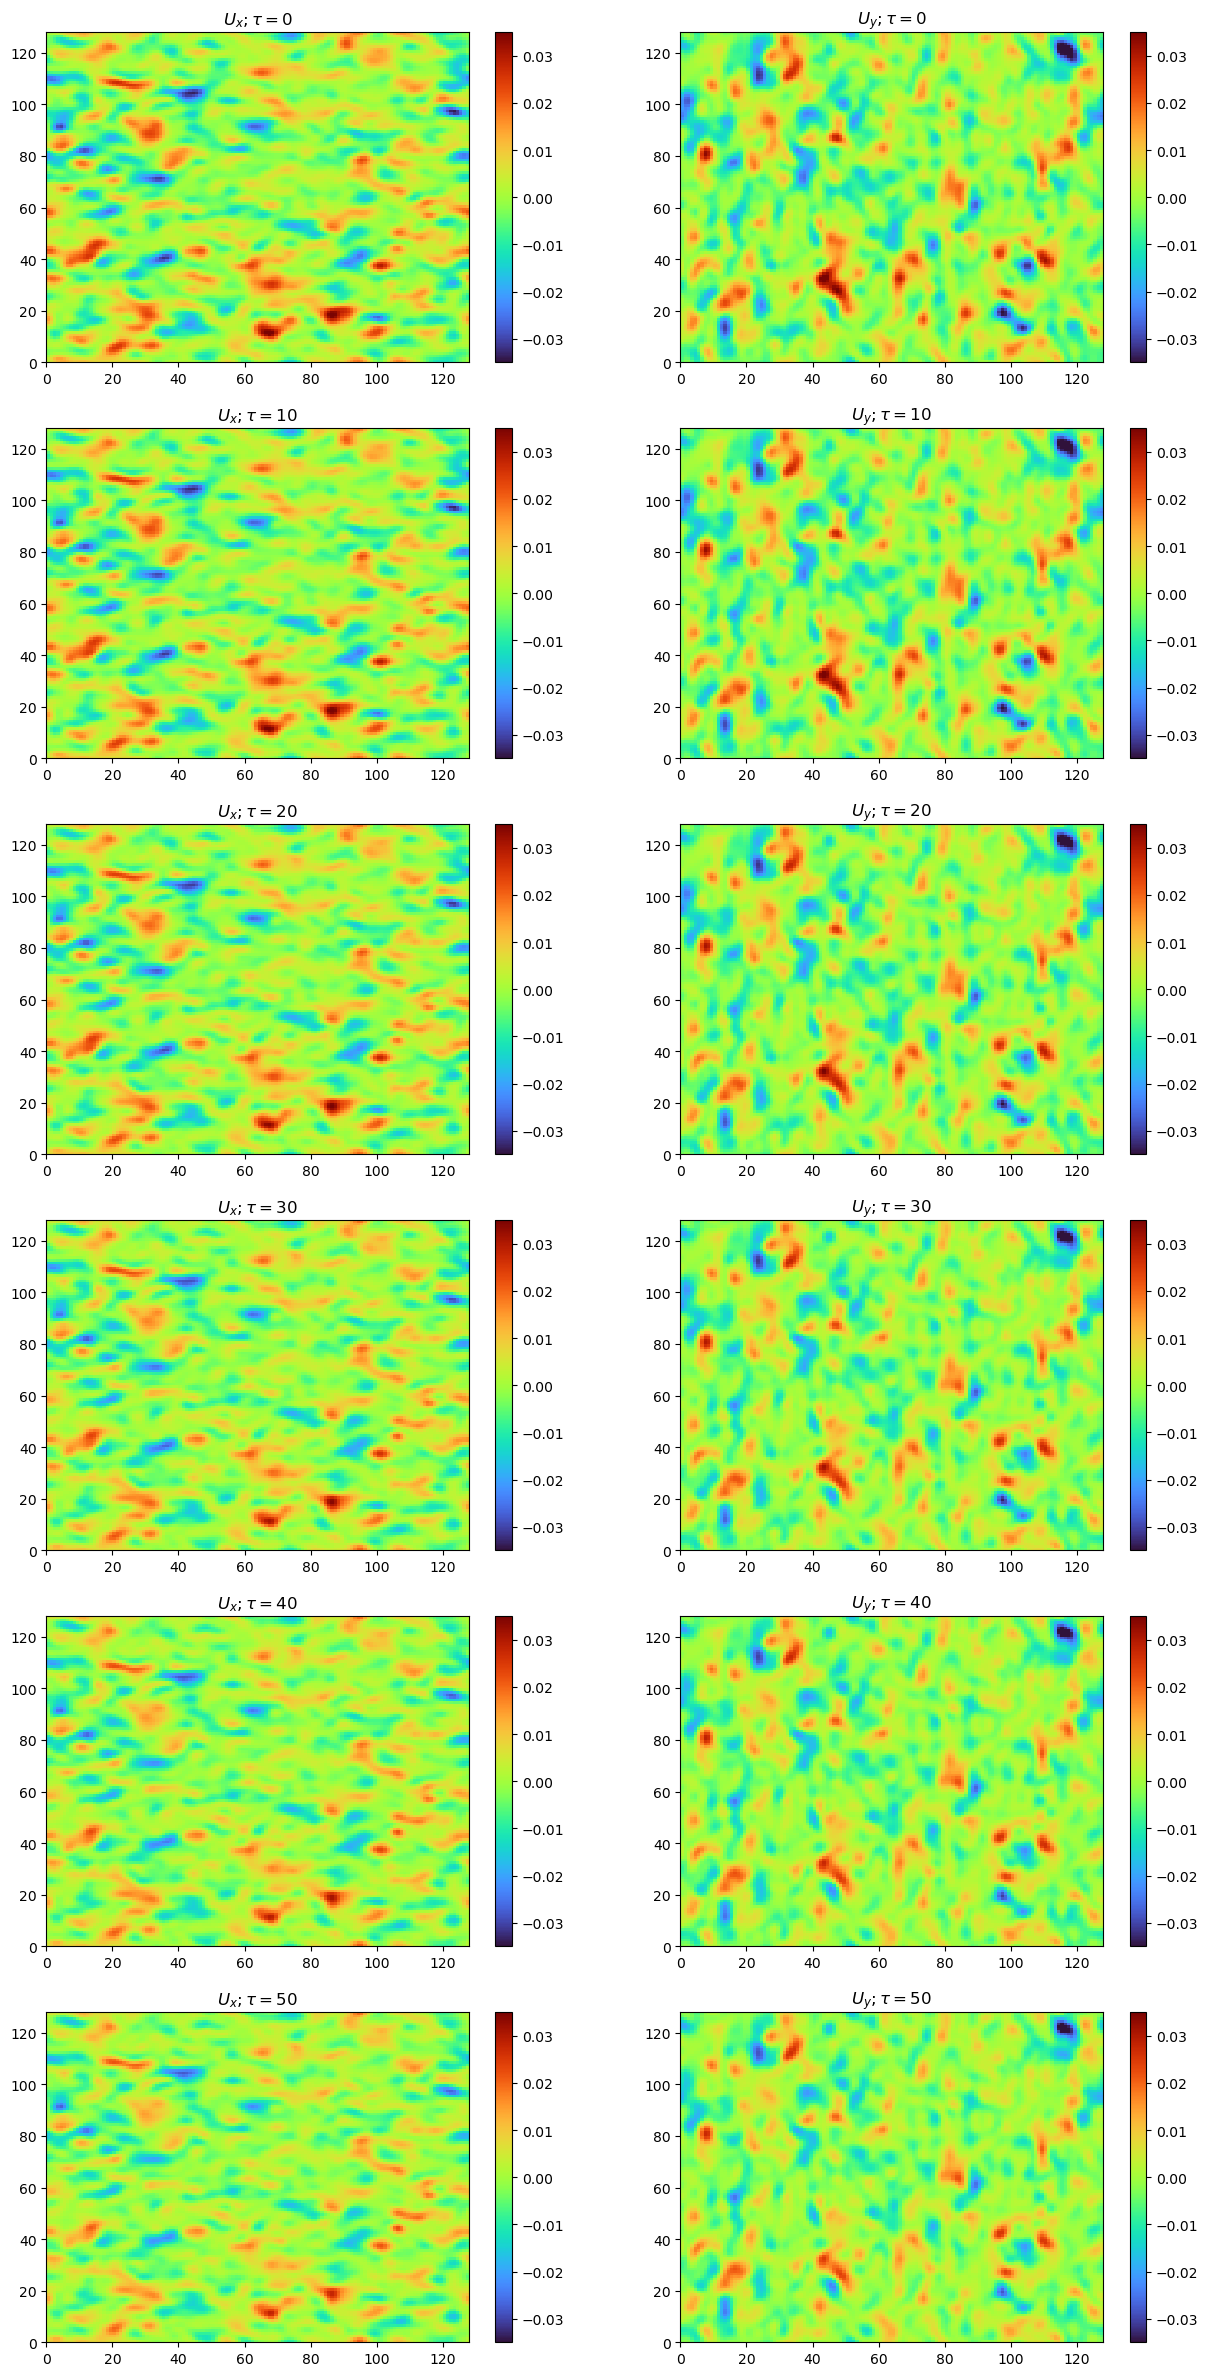

In [7]:
# We plot the gauge links for some time steps

import matplotlib.pyplot as plt 

t_steps = np.shape(ux)[0]
color = 0
N = param['N']

fig, axs = plt.subplots(t_steps//10 + 1, 2, figsize=(15,30))

for i in range(t_steps//10 + 1):
    t=10*i
    
    plot1 = axs[i, 0].pcolormesh(ux_comp[t, :, color].reshape((N,N)), cmap='turbo', vmin=-0.035, vmax=0.035)
    axs[i,0].set_title(r'$U_x; \tau = %i $' %t)
    plt.colorbar(plot1, ax = axs[i,0])
    
    plot2 = axs[i, 1].pcolormesh(uy_comp[t, :, color].reshape((N,N)), cmap='turbo', vmin=-0.035, vmax=0.035)
    axs[i,1].set_title(r'$U_y; \tau = %i $' %t)
    plt.colorbar(plot2, ax = axs[i,1])